# 1. Final Report Generator for Forced Displacement Classification Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from sklearn.metrics import auc
import warnings
warnings.filterwarnings('ignore')

# 2. STYLE CONFIGURATION

In [2]:
FONT_SIZE_LABELS = 30
FONT_SIZE_TICKS = 28
FONT_SIZE_TITLE = 34
FONT_SIZE_ANNOTATIONS = 24
FONT_SIZE_LEGEND = 24
FONT_SIZE_SMALL = 20
DPI_SETTING = 300

# Color palette
COLOR_PRIMARY = '#3498DB'
COLOR_SECONDARY = '#E74C3C'
COLOR_TERTIARY = '#2ECC71'
COLOR_QUATERNARY = '#F39C12'
COLOR_PURPLE = '#9B59B6'
COLOR_TEAL = '#1ABC9C'
COLOR_ORANGE = '#E67E22'
COLOR_GRAY = '#95A5A6'

COLORS = [COLOR_PRIMARY, COLOR_SECONDARY, COLOR_TERTIARY, COLOR_QUATERNARY, 
          COLOR_PURPLE, COLOR_TEAL, COLOR_ORANGE, COLOR_GRAY]

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = FONT_SIZE_TICKS
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = DPI_SETTING

def apply_apa_style(ax):
    """Apply APA style to axes"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

# 3. DEFINE PATHS (RELATIVE TO PROJECT ROOT)

In [3]:
current_dir = Path.cwd()
if current_dir.name == '00_predictive_displacement_model':
    PROJECT_ROOT = current_dir.parent
else:
    PROJECT_ROOT = current_dir

CLASSICAL_METRICS = PROJECT_ROOT / "00_predictive_displacement_model/db/02a_classical_models/metrics/all_architectures_tested_comprehensive.xlsx"
NEURAL_METRICS = PROJECT_ROOT / "00_predictive_displacement_model/db/02b_neural_networks/metrics/all_architectures_tested_comprehensive.xlsx"
OUTPUT_DIR = PROJECT_ROOT / "00_predictive_displacement_model/fig/final_report"

# 4. LOAD BEST MODELS METRICS

In [4]:
def load_best_models():
    """Load metrics for best models from both classical and neural networks"""
    
    # Load all architectures
    df_classical = pd.read_excel(CLASSICAL_METRICS)
    df_neural = pd.read_excel(NEURAL_METRICS)
    
    # Filter for best models
    best_classical_names = ['Logistic_Regression', 'Random_Forest', 'XGBoost']
    best_neural_names = ['ResNet_Style', 'Deep']
    
    # Get best architecture for each model
    best_models = []
    for model_name in best_classical_names:
        model_data = df_classical[df_classical['Model'].str.contains(model_name, na=False)]
        if not model_data.empty:
            best_arch = model_data.loc[model_data['Test_F1'].idxmax()]
            best_models.append(best_arch)
    
    for model_name in best_neural_names:
        model_data = df_neural[df_neural['Model'].str.contains(model_name, na=False)]
        if not model_data.empty:
            best_arch = model_data.loc[model_data['Test_F1'].idxmax()]
            best_models.append(best_arch)
    
    df_best = pd.DataFrame(best_models)
    return df_best

In [5]:
df_best = load_best_models()

# 5. CREATE METRICS COMPARISON TABLE

In [6]:
def create_metrics_table(df_best):
    """Create comprehensive metrics comparison table"""
    
    table_data = []
    
    for idx, row in df_best.iterrows():
        model_name = row['Model'].split('_')[0] if '_' in row['Model'] else row['Model']
        
        table_data.append({
            'Model': model_name,
            'Training Time (min)': f"{row['Training_Time_Minutes']:.2f}",
            'Accuracy Train': f"{row['Train_Accuracy']:.4f}",
            'Precision Train': f"{row['Train_Precision']:.4f}",
            'Recall Train': f"{row['Train_Recall']:.4f}",
            'F1-Score Train': f"{row['Train_F1']:.4f}",
            'Accuracy Test': f"{row['Test_Accuracy']:.4f}",
            'Precision Test': f"{row['Test_Precision']:.4f}",
            'Recall Test': f"{row['Test_Recall']:.4f}",
            'F1-Score Test': f"{row['Test_F1']:.4f}",
            'ROC-AUC Test': f"{row['Test_ROC_AUC']:.4f}"
        })
    
    df_table = pd.DataFrame(table_data)
    
    # Save to CSV
    df_table.to_csv(OUTPUT_DIR / 'metrics_comparison_table.csv', index=False)
    
    return df_table

In [7]:
df_table = create_metrics_table(df_best)
df_table

Model Training Time (min) Accuracy Train Precision Train Recall Train  \
0  Logistic               48.50         0.7416          0.6304       0.7471   
1    Random                9.54         0.9284          0.8822       0.9332   
2   XGBoost                9.34         0.8682          0.7884       0.8851   
3    ResNet               90.77         0.8716          0.9872       0.6652   
4      Deep               74.74         0.8286          0.9752       0.5559   

  F1-Score Train Accuracy Test Precision Test Recall Test F1-Score Test  \
0         0.6838        0.7416         0.6305      0.7471        0.6839   
1         0.9070        0.9188         0.8712      0.9187        0.8943   
2         0.8339        0.8629         0.7818      0.8788        0.8274   
3         0.7948        0.8673         0.9822      0.6572        0.7875   
4         0.7082        0.8261         0.9716      0.5512        0.7034   

  ROC-AUC Test  
0       0.8185  
1       0.9822  
2       0.9510  
3       0.9622  
4       0.9438

# 6. CREATE BAR CHART COMPARISON

In [8]:
def create_bar_comparison(df_best):
    """Create grouped bar chart comparing test metrics across models"""
    
    models = []
    metrics_data = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': [],
        'ROC-AUC': []
    }
    
    for idx, row in df_best.iterrows():
        model_name = row['Model'].split('_')[0] if '_' in row['Model'] else row['Model']
        models.append(model_name)
        metrics_data['Accuracy'].append(row['Test_Accuracy'])
        metrics_data['Precision'].append(row['Test_Precision'])
        metrics_data['Recall'].append(row['Test_Recall'])
        metrics_data['F1-Score'].append(row['Test_F1'])
        metrics_data['ROC-AUC'].append(row['Test_ROC_AUC'])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 10))
    
    x = np.arange(len(models))
    width = 0.15
    multiplier = 0
    
    for (metric_name, metric_values), color in zip(metrics_data.items(), COLORS[:5]):
        offset = width * multiplier
        rects = ax.bar(x + offset, metric_values, width, label=metric_name, color=color, 
                      edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 0.01,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=FONT_SIZE_SMALL-4, fontweight='bold')
        
        multiplier += 1
    
    # Formatting
    ax.set_xlabel('Model', fontsize=FONT_SIZE_LABELS, fontweight='bold')
    ax.set_ylabel('Score', fontsize=FONT_SIZE_LABELS, fontweight='bold')
    ax.set_title('Test Metrics Comparison Across Models', fontsize=FONT_SIZE_TITLE, fontweight='bold', pad=20)
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(models, fontsize=FONT_SIZE_TICKS)
    ax.legend(loc='upper left', fontsize=FONT_SIZE_LEGEND)
    ax.set_ylim([0.5, 1.05])
    
    apply_apa_style(ax)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'metrics_bar_comparison.png', dpi=DPI_SETTING, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: metrics_bar_comparison.png")

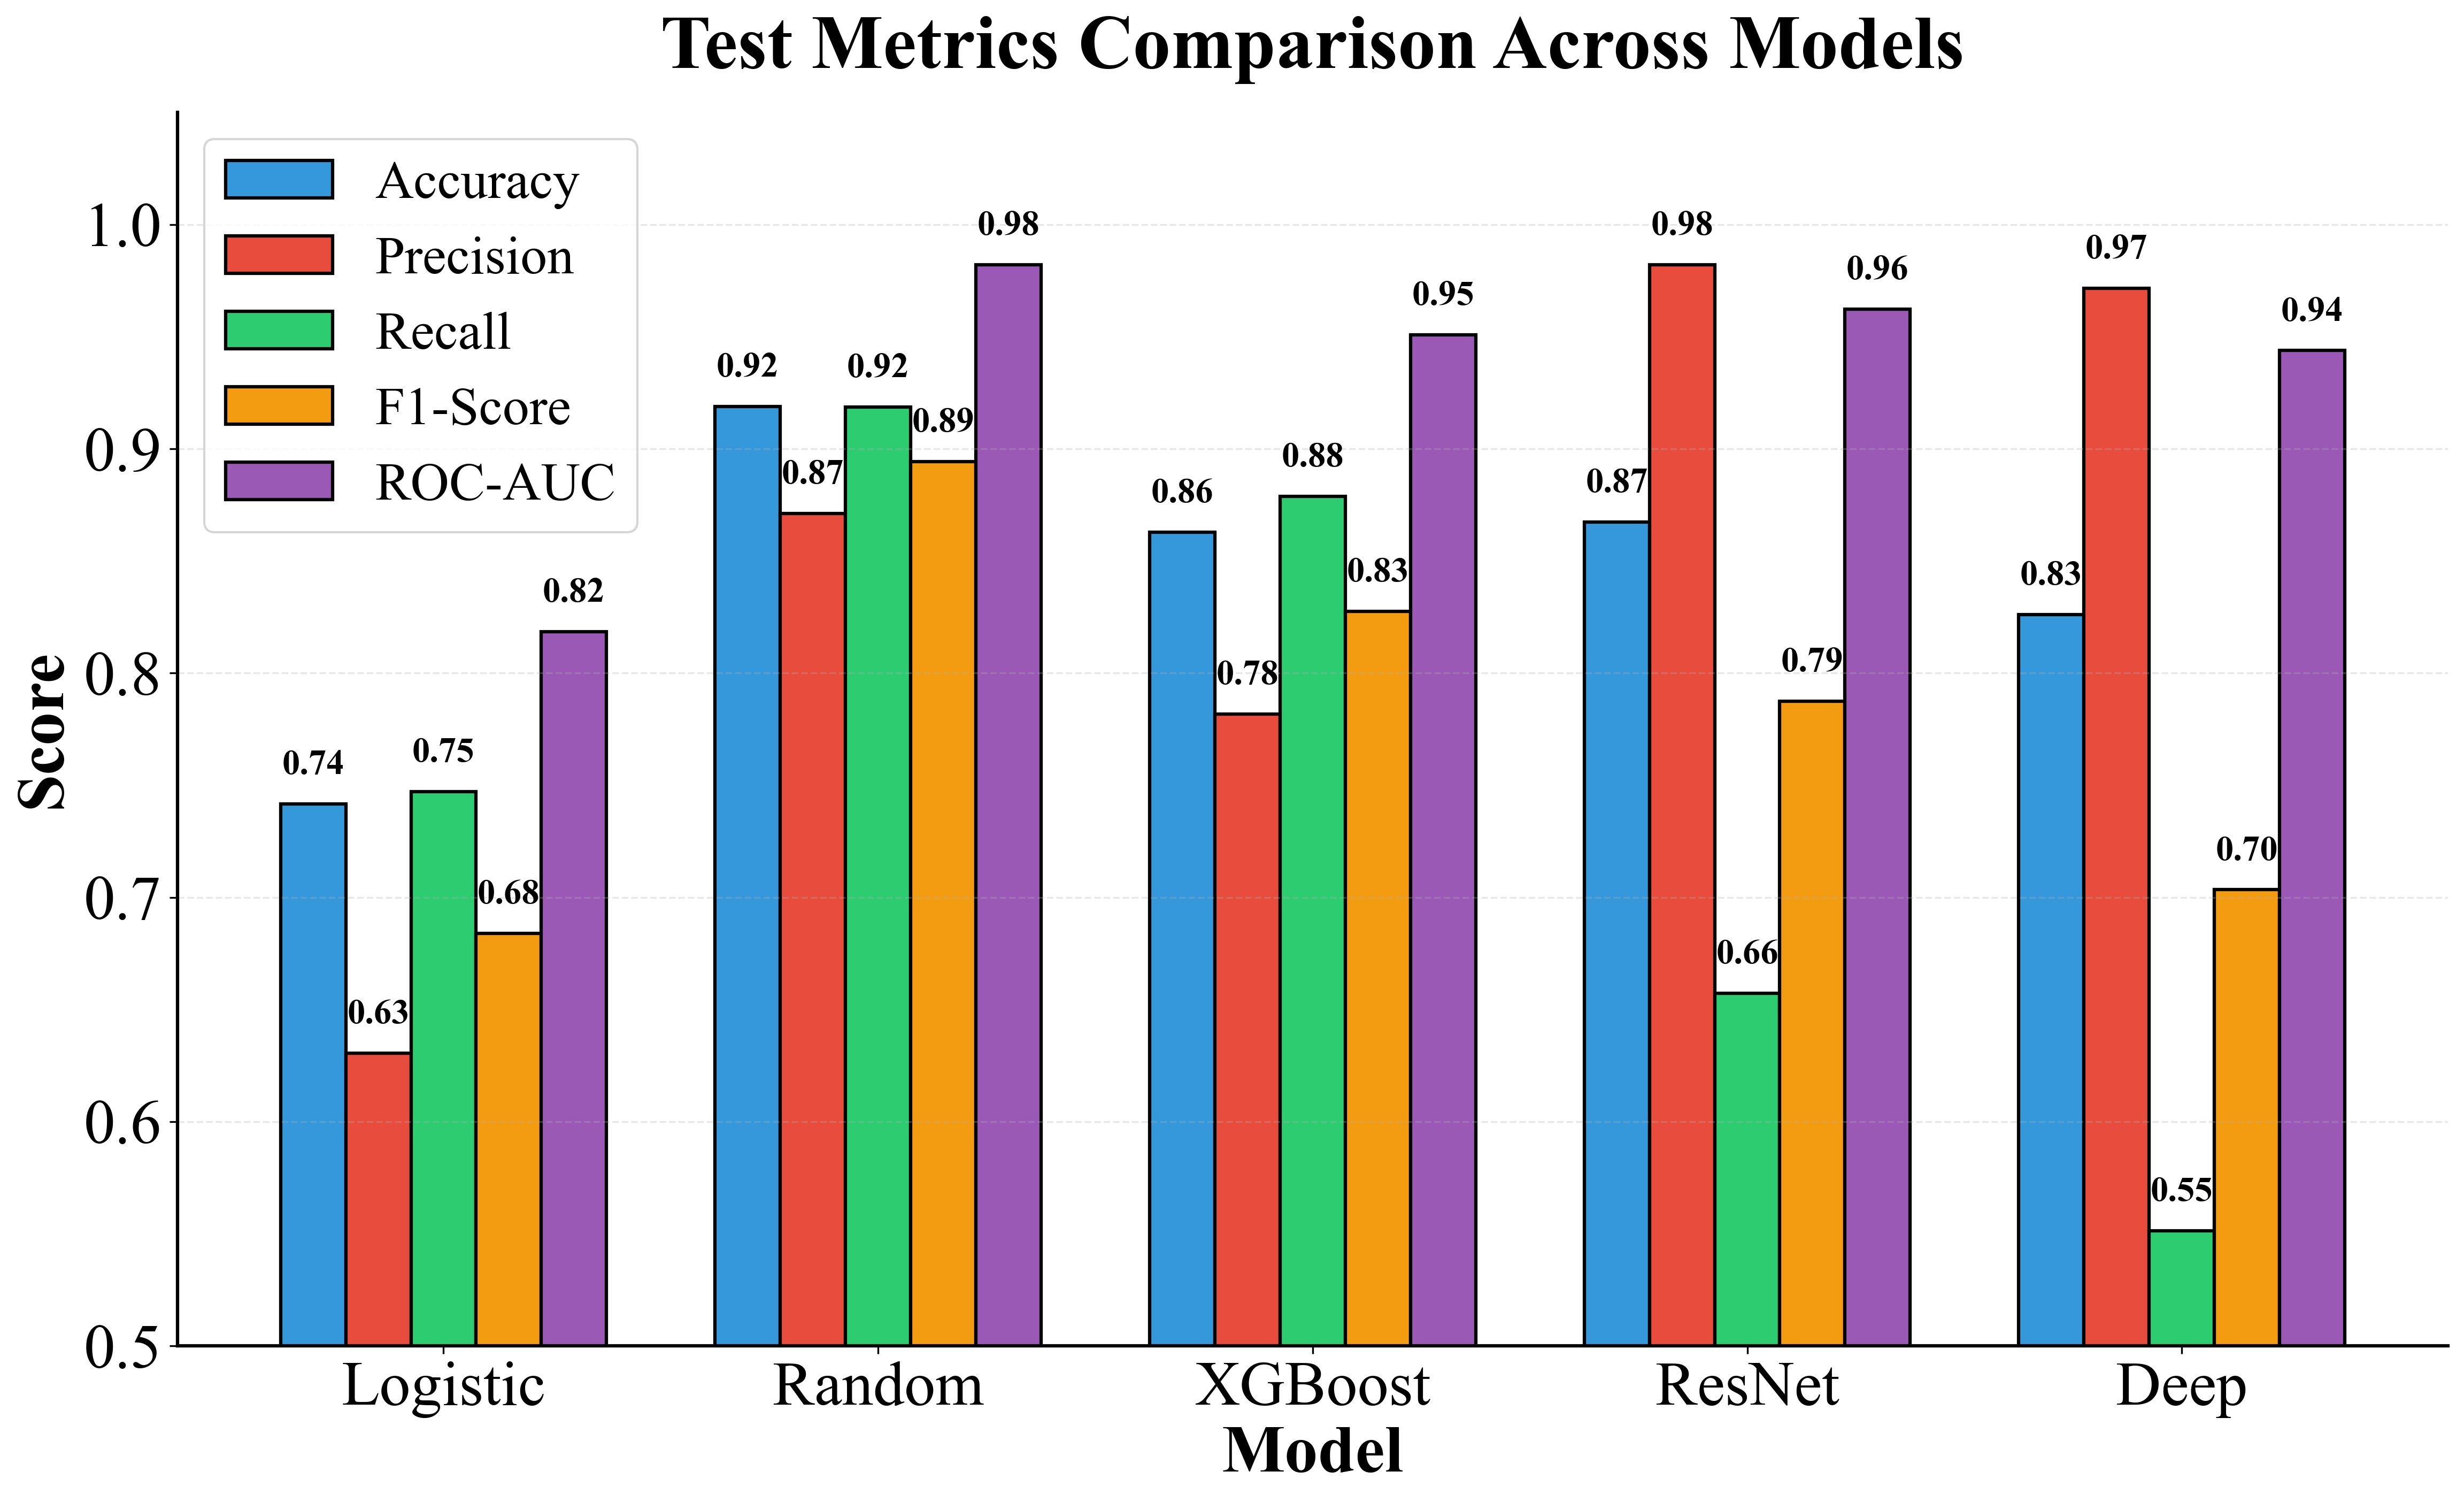

Saved: metrics_bar_comparison.png


In [9]:
create_bar_comparison(df_best)

# 7. CREATE INDIVIDUAL CONFUSION MATRICES

In [10]:
def create_confusion_matrices(df_best):
    """Create individual confusion matrix for each model (based on 004_figures.py)"""
    
    for idx, row in df_best.iterrows():
        model_name = row['Model']
        
        # Determine folder based on model type
        if model_name in ['Logistic_Regression', 'Random_Forest', 'XGBoost']:
            cm_file = PROJECT_ROOT / f"00_predictive_displacement_model/db/02a_classical_models/model_data/confusion_matrices/{model_name}_best_confusion_matrix.xlsx"
        else:
            cm_file = PROJECT_ROOT / f"00_predictive_displacement_model/db/02b_neural_networks/model_data/confusion_matrices/{model_name}_best_confusion_matrix.xlsx"
        
        if not cm_file.exists():
            print(f"  ⚠ Confusion matrix not found for {model_name}")
            continue
            
        # Load confusion matrix
        cm_df = pd.read_excel(cm_file, index_col=0)
        cm = cm_df.values
        
        # Normalize
        cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-15)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(cm_normalized, cmap='Blues', aspect='auto', vmin=0, vmax=1)
        
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Others (0)', 'Displacement (1)'], fontsize=FONT_SIZE_TITLE)
        ax.set_yticklabels(['Others (0)', 'Displacement (1)'], fontsize=FONT_SIZE_TITLE, rotation=90, va='center')
        
        ax.set_ylabel('True Label', fontsize=FONT_SIZE_TITLE, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=FONT_SIZE_TITLE, fontweight='bold')
        ax.set_title(f'Confusion Matrix - {model_name}', fontsize=FONT_SIZE_TITLE, fontweight='bold', pad=20)
        
        # Annotations with values and percentages
        for i in range(2):
            for j in range(2):
                proportion = cm_normalized[i, j] * 100
                text_label = f'{cm[i, j]:,}\n({proportion:.1f}%)'
                
                if (i == 0 and j == 0) or (i == 1 and j == 1):
                    color = "white"
                else:
                    color = "black"
                    
                ax.text(j, i, text_label, ha="center", va="center", 
                       color=color, fontsize=FONT_SIZE_TITLE, fontweight='bold')
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Proportion', fontsize=FONT_SIZE_TITLE, fontweight='bold')
        cbar.ax.tick_params(labelsize=FONT_SIZE_TITLE)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f'confusion_matrix_{model_name}.png', dpi=DPI_SETTING, bbox_inches='tight')
        plt.show()
        
        print(f"Confusion matrix saved: {model_name}")

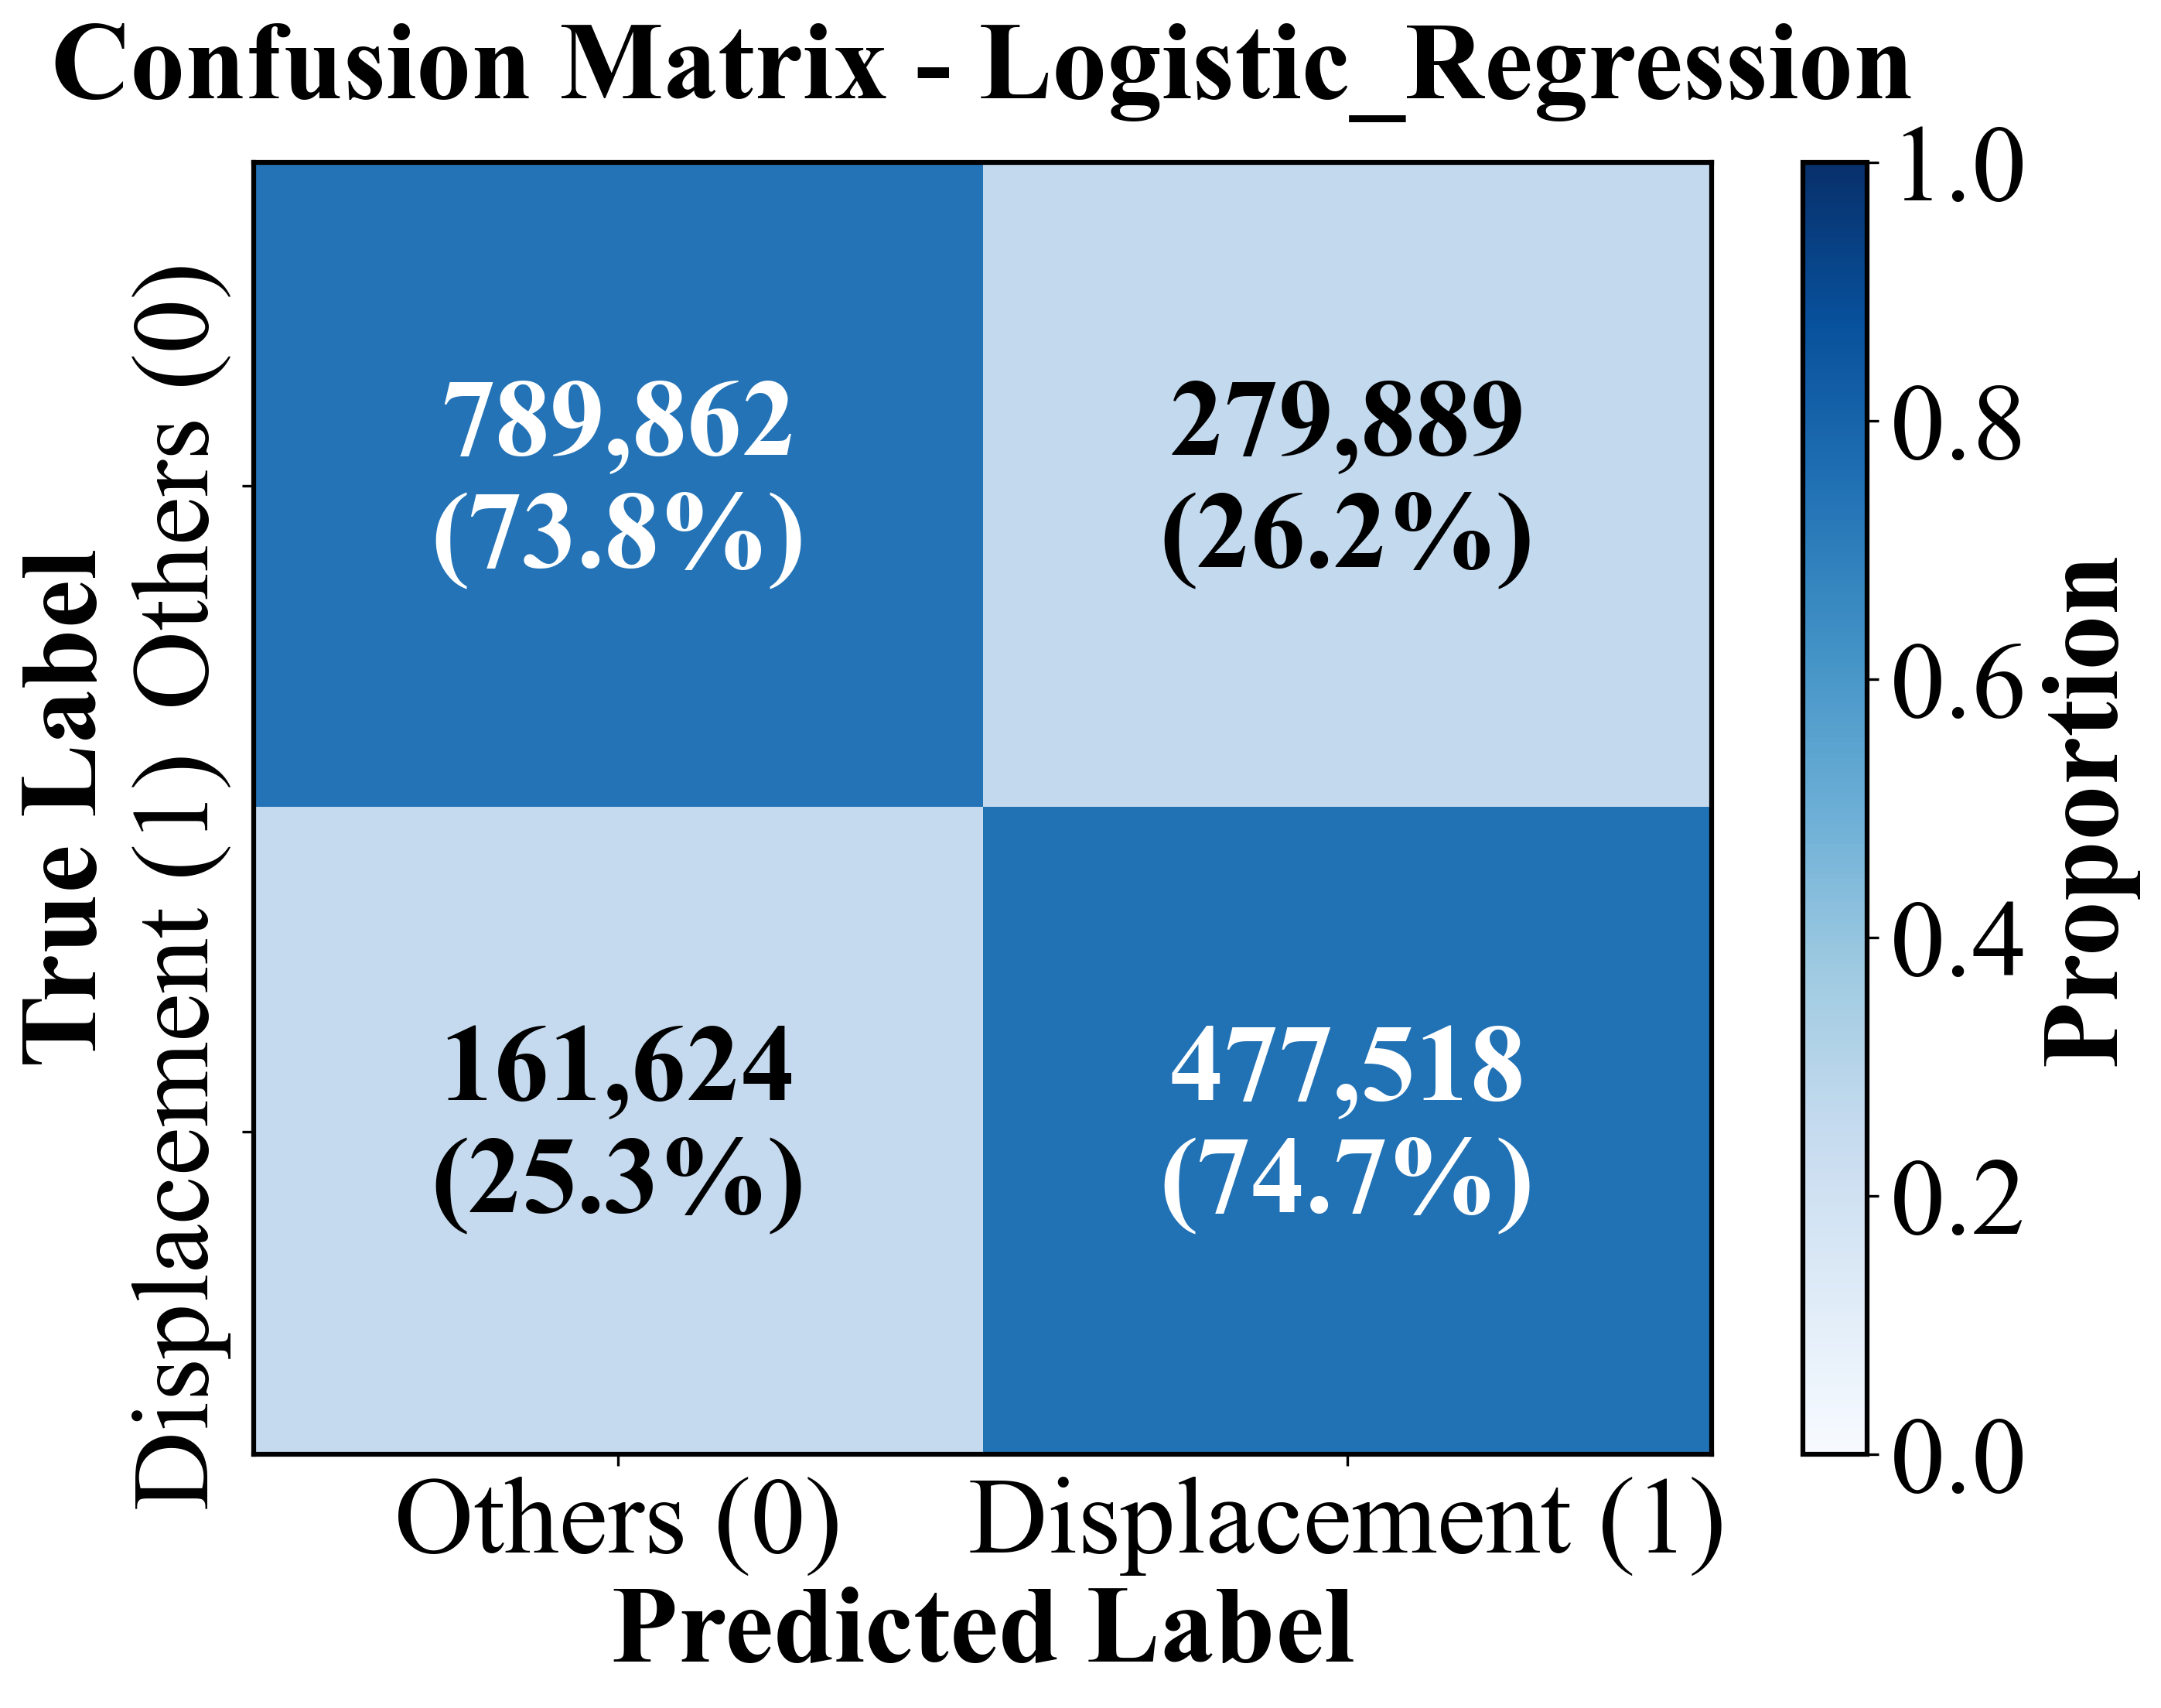

Confusion matrix saved: Logistic_Regression


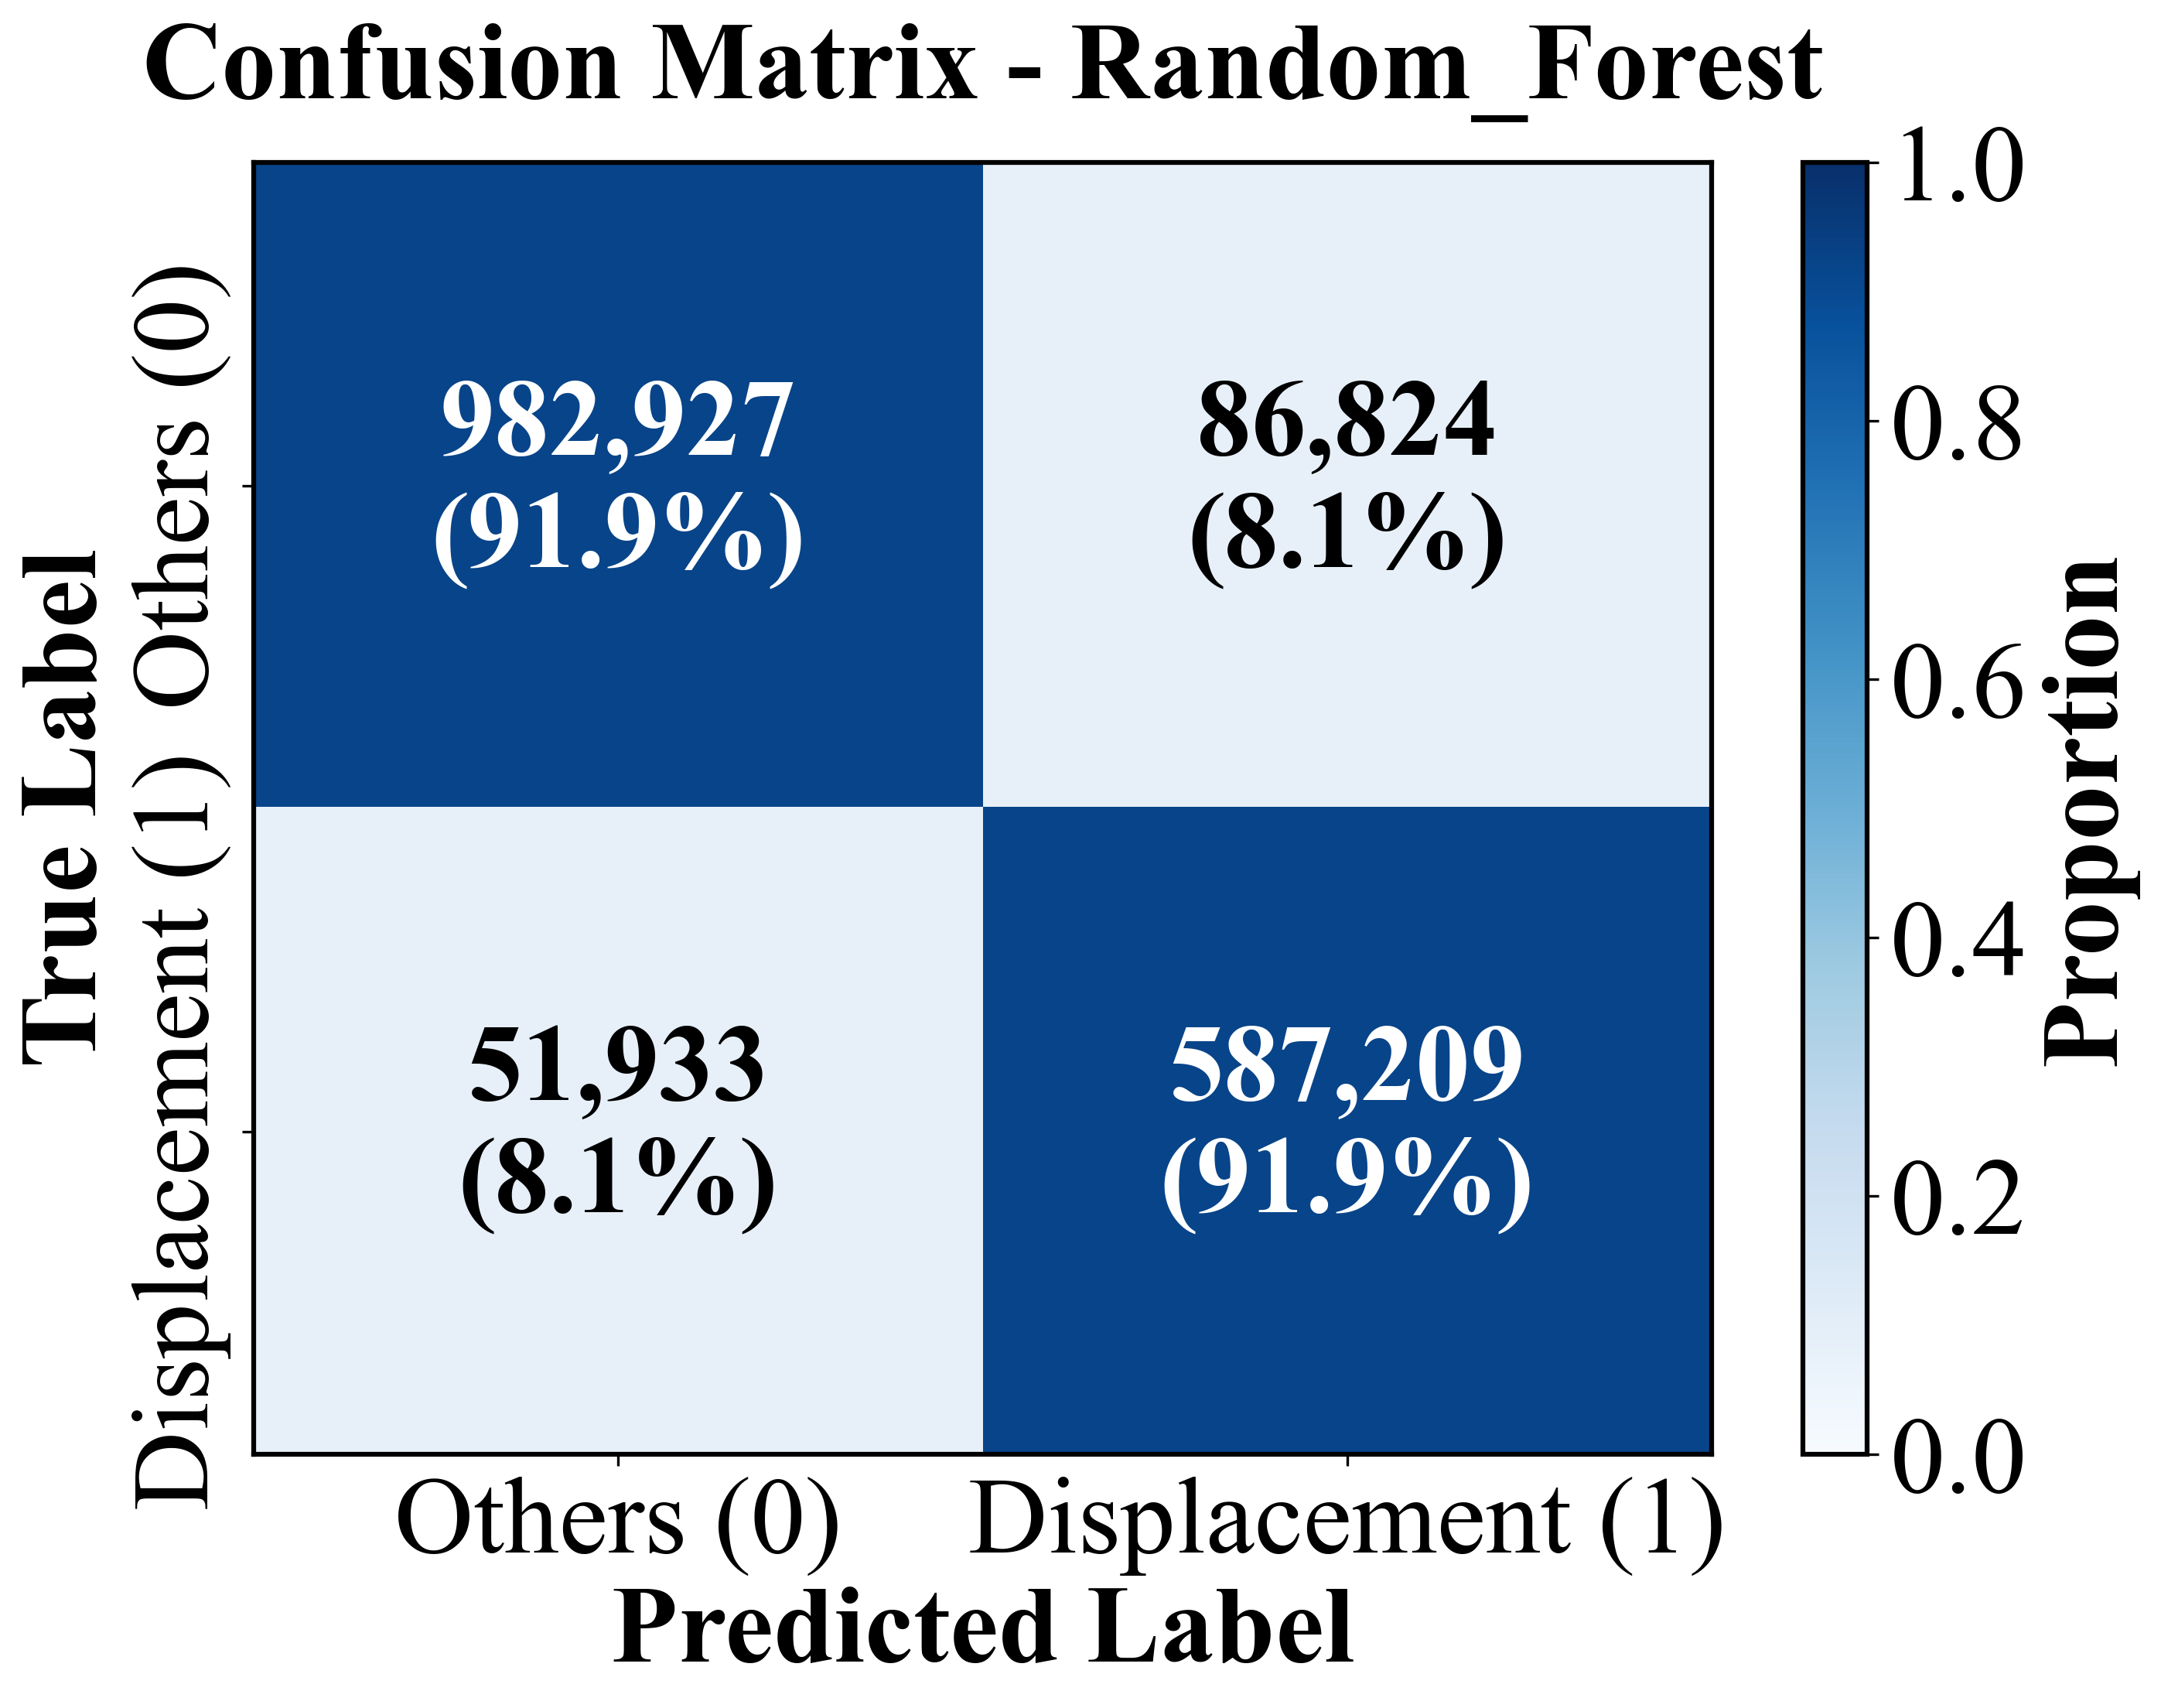

Confusion matrix saved: Random_Forest


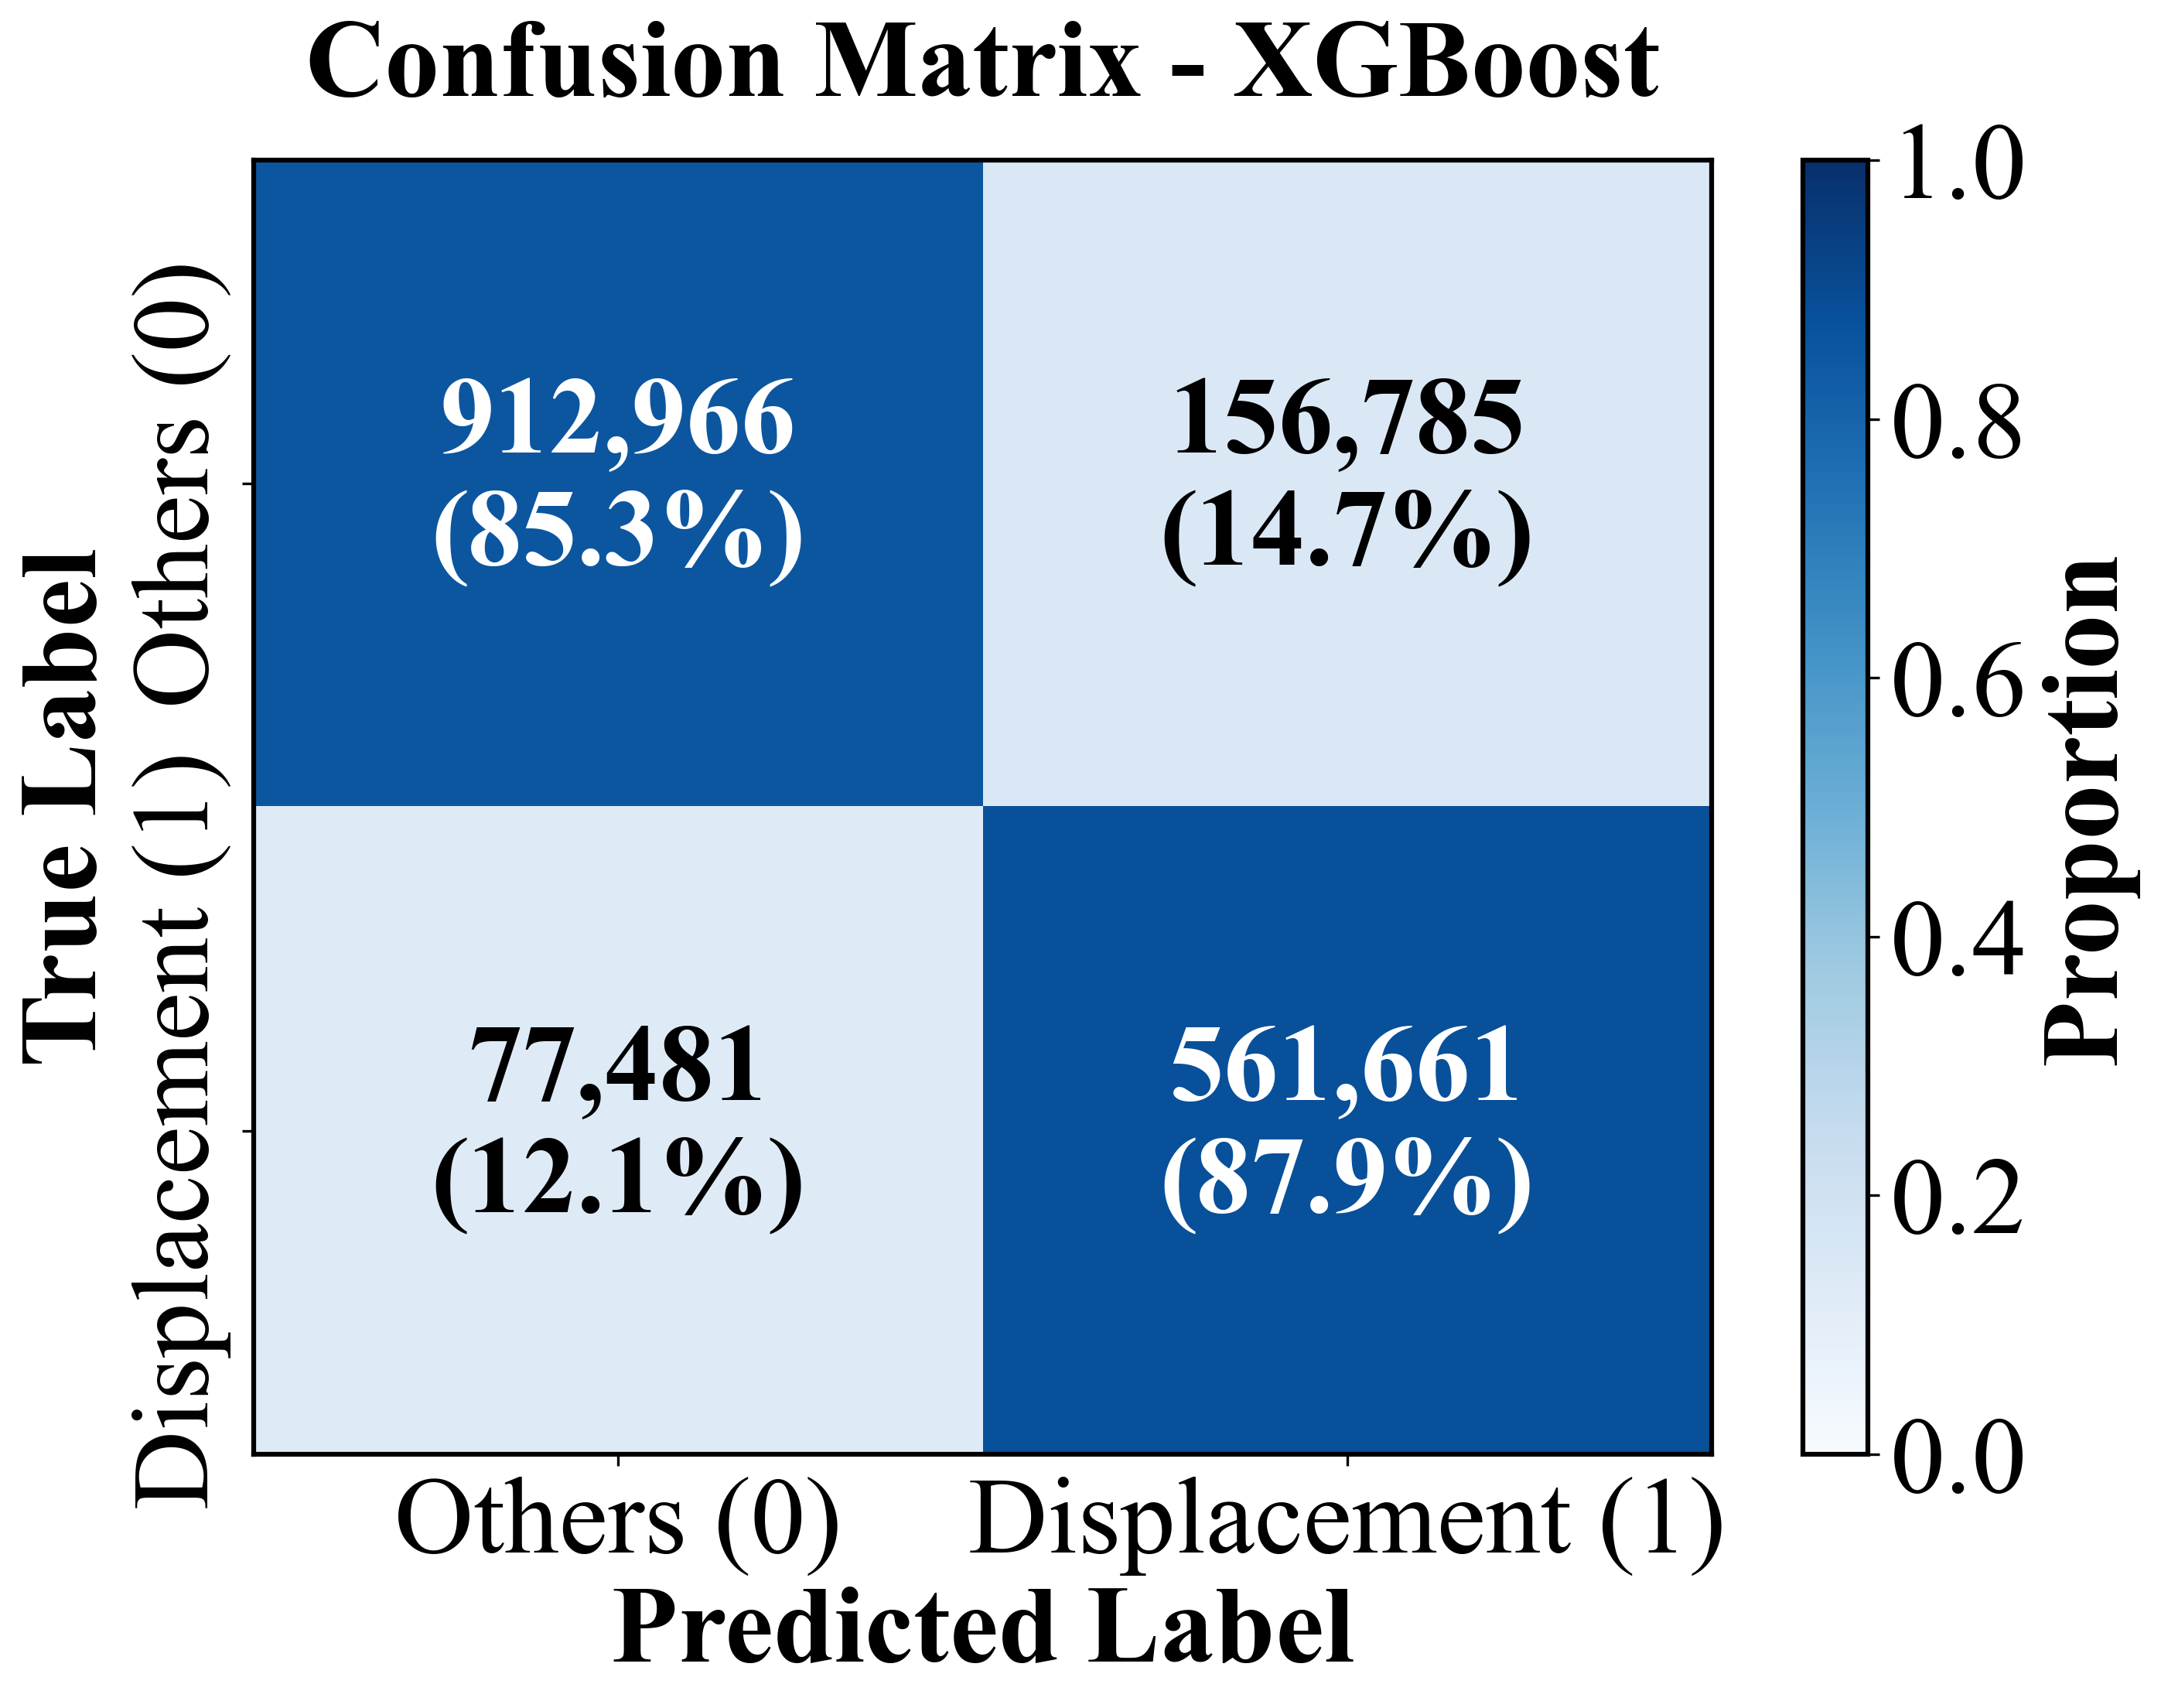

Confusion matrix saved: XGBoost


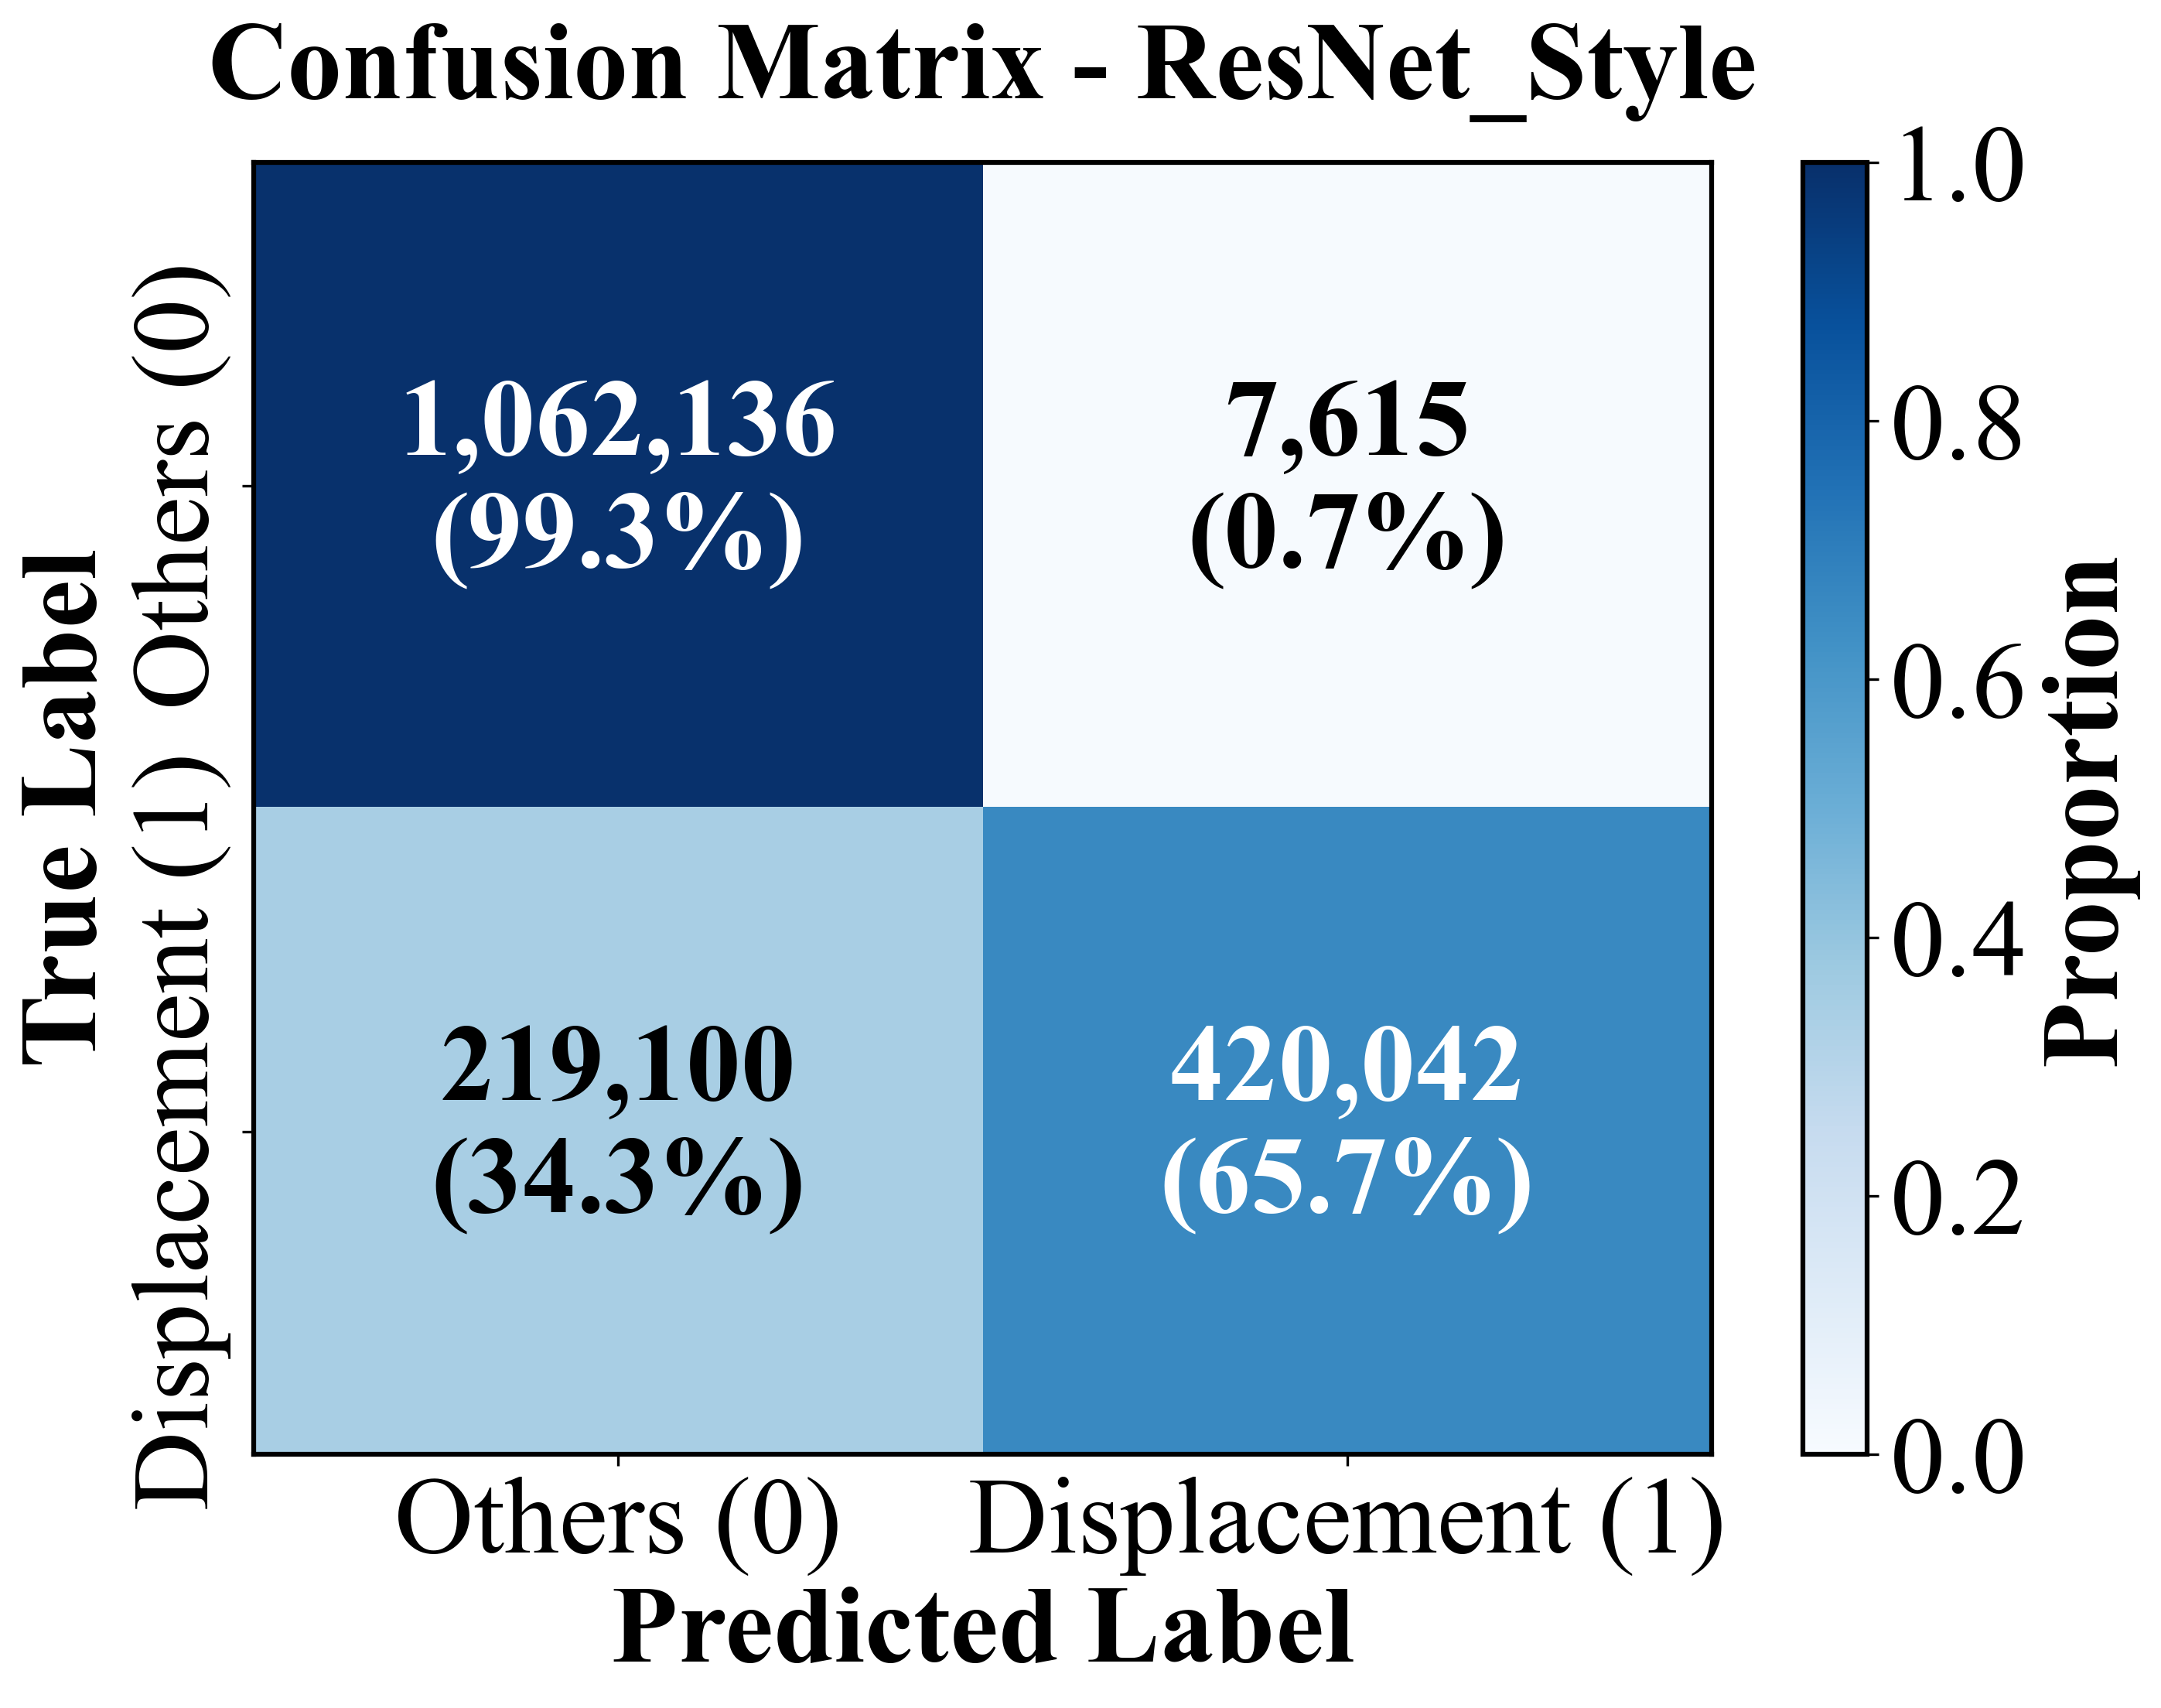

Confusion matrix saved: ResNet_Style


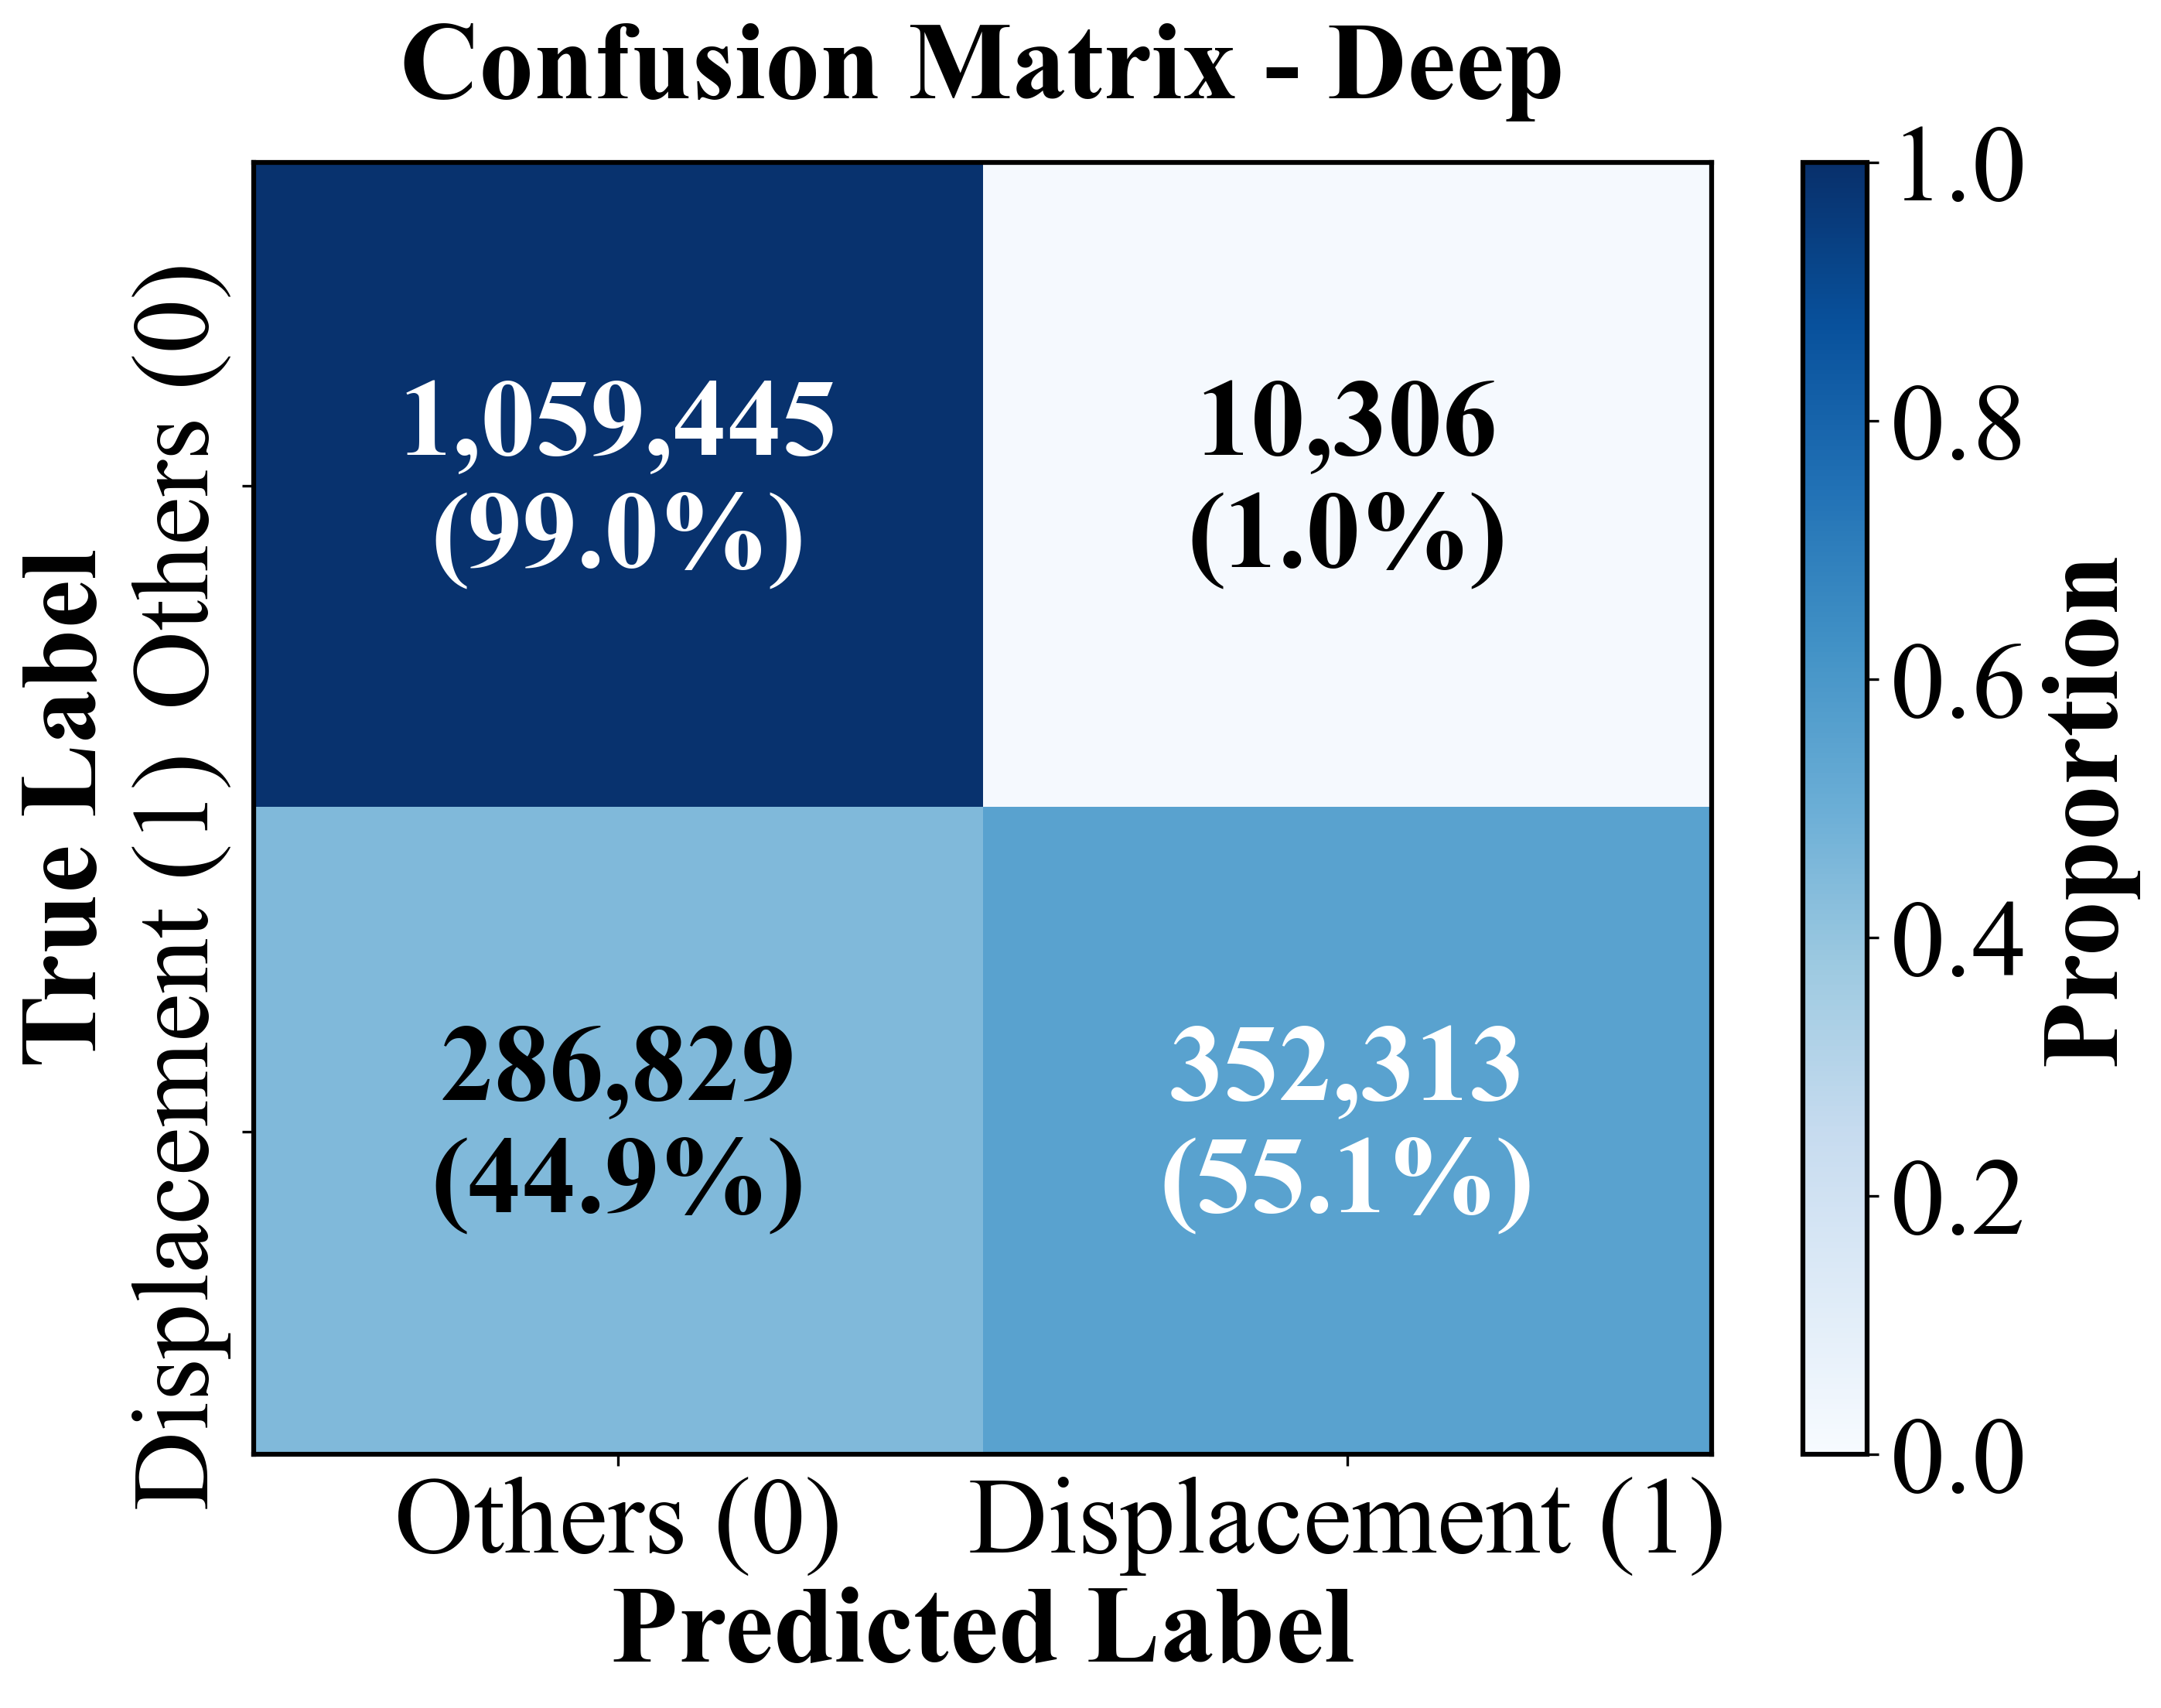

Confusion matrix saved: Deep


In [11]:
create_confusion_matrices(df_best)

# 8. CREATE COMBINED ROC CURVE

In [12]:
def create_combined_roc_curve(df_best):
    """Create combined ROC curve for all models (based on 004_figures.py)"""
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    roc_data = []
    
    for idx, row in df_best.iterrows():
        model_name = row['Model']
        
        # Determine folder based on model type
        if model_name in ['Logistic_Regression', 'Random_Forest', 'XGBoost']:
            roc_file = PROJECT_ROOT / f"00_predictive_displacement_model/db/02a_classical_models/model_data/roc_data/{model_name}_best_roc_curve.xlsx"
        else:
            roc_file = PROJECT_ROOT / f"00_predictive_displacement_model/db/02b_neural_networks/model_data/roc_data/{model_name}_best_roc_curve.xlsx"
        
        if not roc_file.exists():
            print(f"  ⚠ ROC data not found for {model_name}")
            continue
            
        # Load ROC data
        roc_df = pd.read_excel(roc_file)
        fpr = roc_df['FPR'].values
        tpr = roc_df['TPR'].values
        roc_auc = roc_df['AUC'].values[0]
        
        # Plot
        display_name = model_name.replace('_', ' ')
        ax.plot(fpr, tpr, color=COLORS[idx % len(COLORS)], lw=3, 
                label=f'{display_name} (AUC = {roc_auc:.4f})')
        
        roc_data.append({
            'model': model_name,
            'auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr
        })
        
        print(f"  ✓ ROC curve loaded: {model_name} (AUC = {roc_auc:.4f})")
    
    # Diagonal line
    ax.plot([0, 1], [0, 1], color=COLOR_SECONDARY, lw=2, linestyle='--', 
            label='Random Classifier (AUC = 0.5000)')
    
    # Formatting
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=FONT_SIZE_LABELS, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=FONT_SIZE_LABELS, fontweight='bold')
    ax.set_title('ROC Curves - All Models', fontsize=FONT_SIZE_TITLE, fontweight='bold', pad=20)
    ax.legend(loc='lower right', fontsize=FONT_SIZE_LEGEND)
    
    apply_apa_style(ax)
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'roc_curves_combined.png', dpi=DPI_SETTING, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: roc_curves_combined.png")

  ✓ ROC curve loaded: Logistic_Regression (AUC = 0.8185)
  ✓ ROC curve loaded: Random_Forest (AUC = 0.9822)
  ✓ ROC curve loaded: XGBoost (AUC = 0.9510)
  ✓ ROC curve loaded: ResNet_Style (AUC = 0.9622)
  ✓ ROC curve loaded: Deep (AUC = 0.9438)


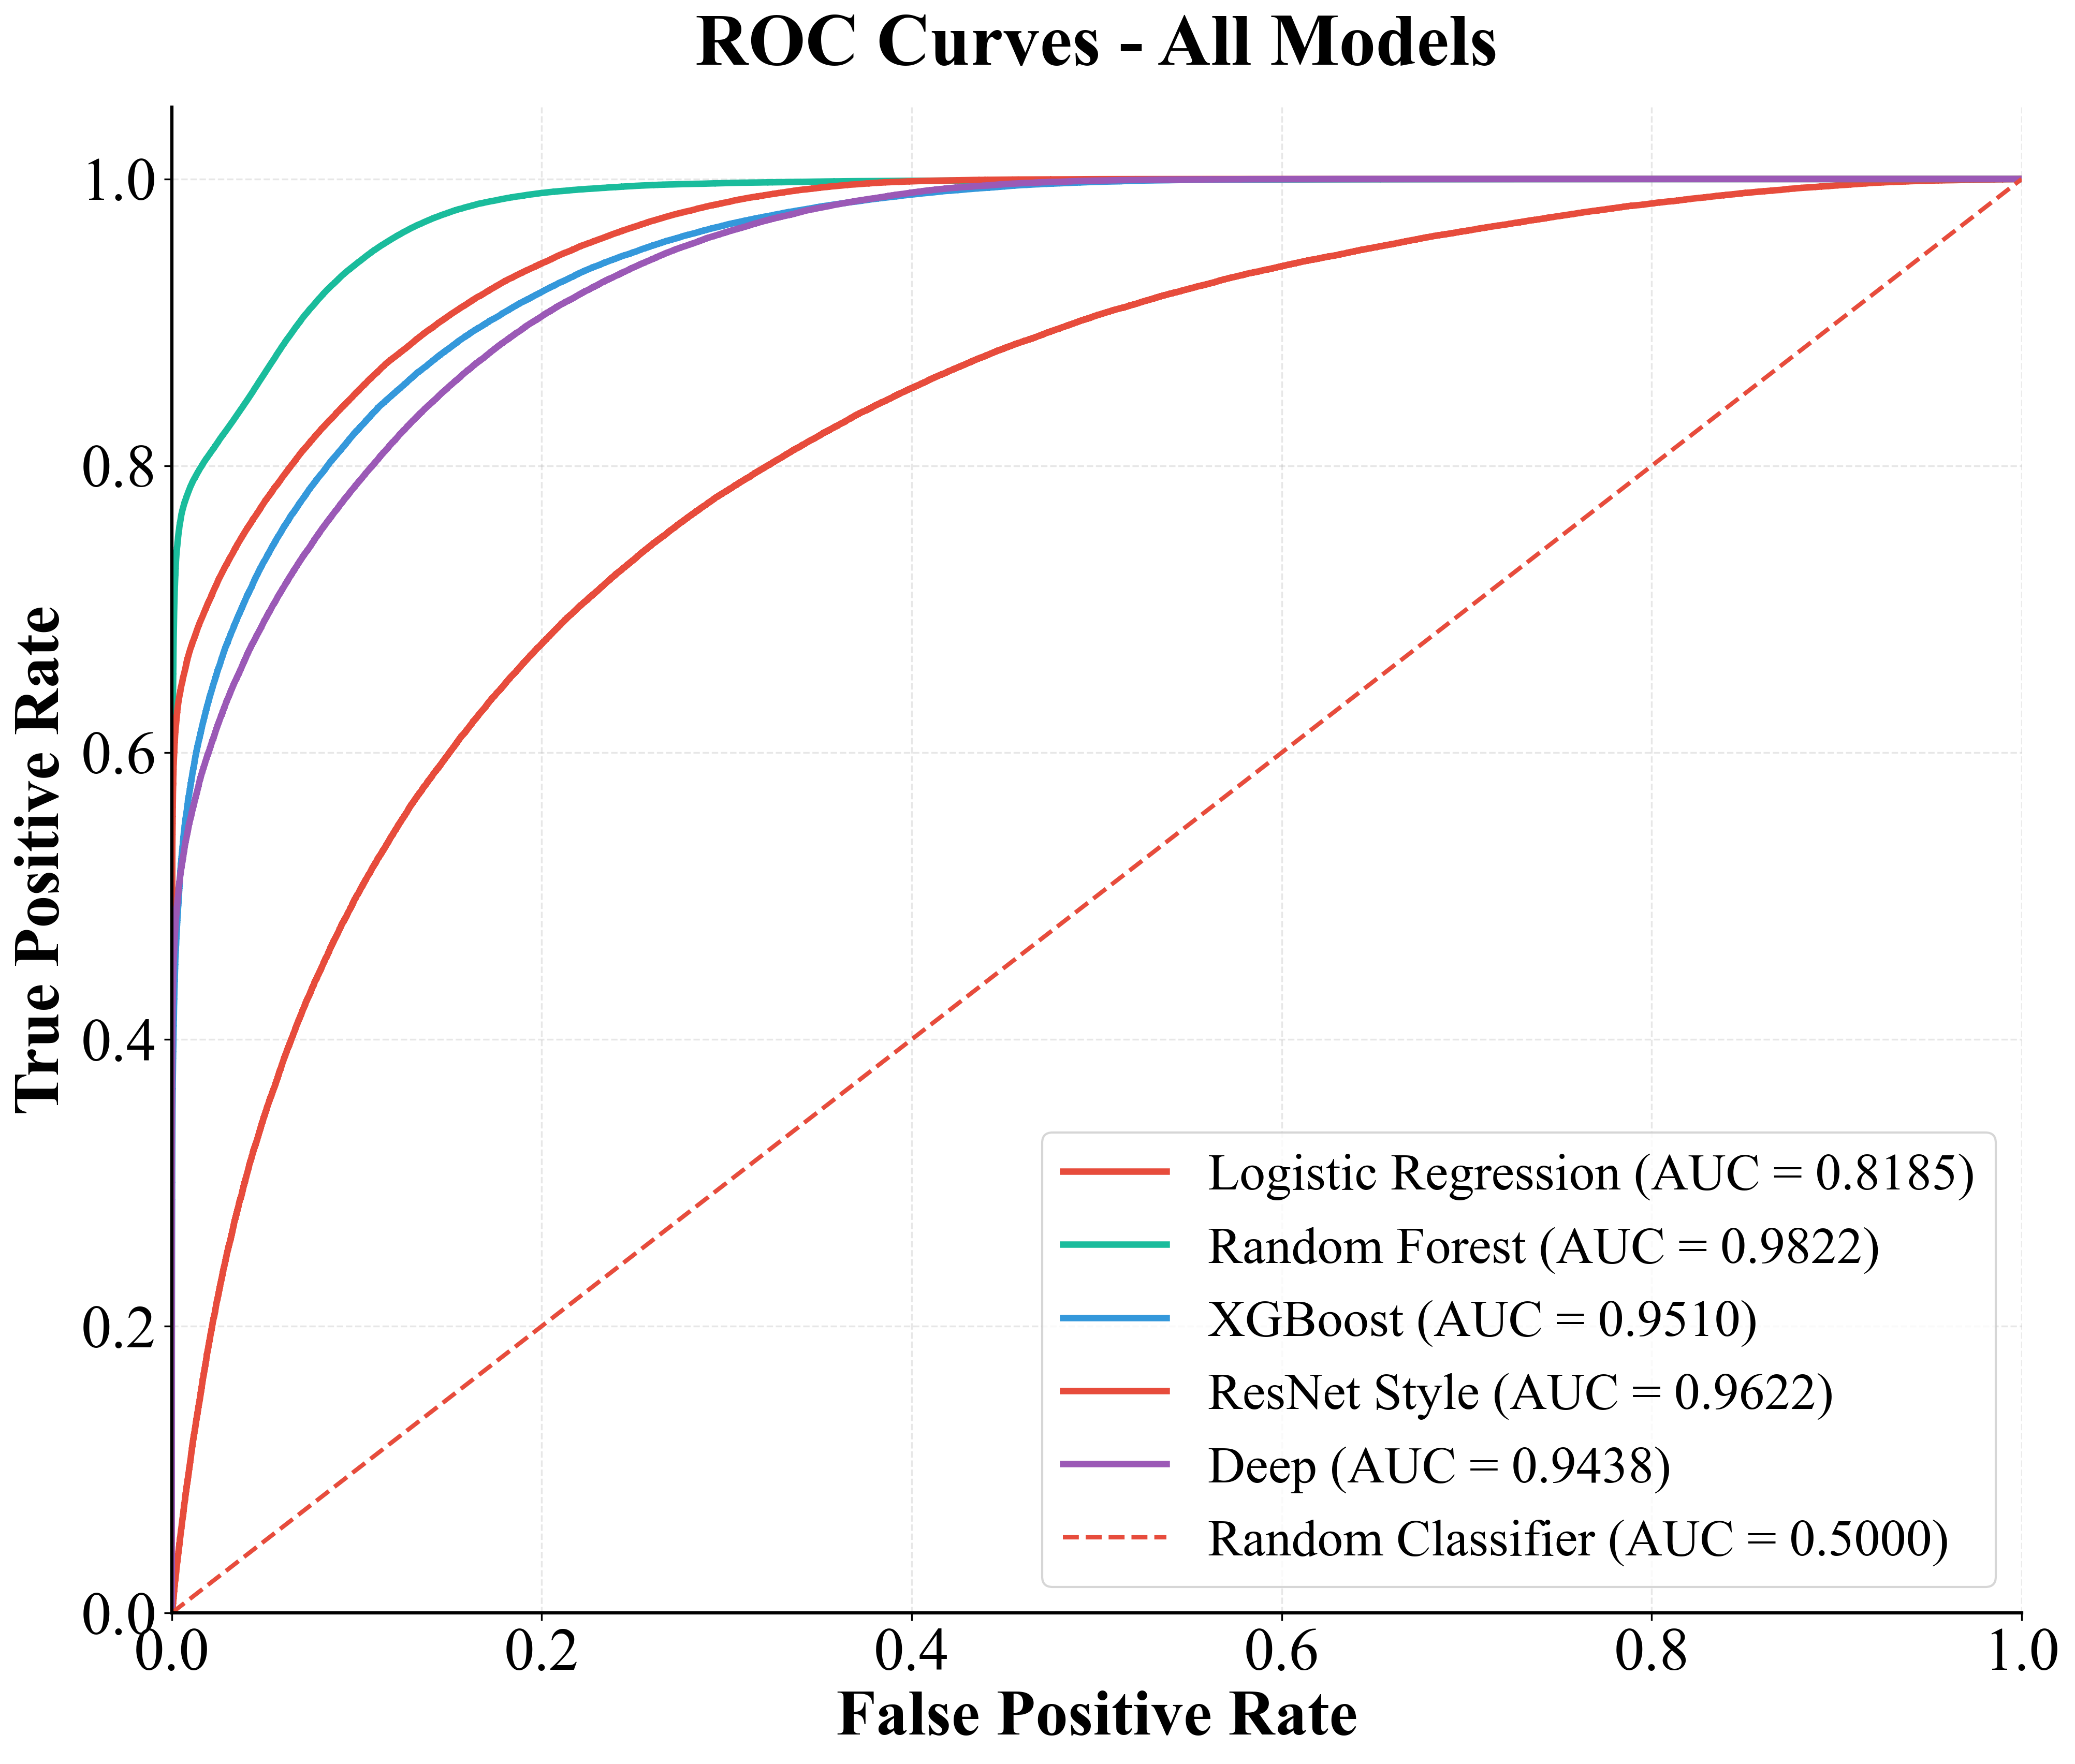

Saved: roc_curves_combined.png


In [13]:
create_combined_roc_curve(df_best)

# 9. CREATE FEATURE IMPORTANCE PLOT

In [14]:
def create_feature_importance():
    """Create feature importance plot for Random Forest (based on 004_figures.py)"""
    
    # Load Random Forest model
    model_path = PROJECT_ROOT / "00_predictive_displacement_model/db/02a_classical_models/saved_models/Random_Forest_best_model.pkl"
    
    if not model_path.exists():
        print("  ⚠ Random Forest model not found")
        return
    
    model = joblib.load(model_path)
    print(f"✓ Model loaded: {model.n_features_in_} features")
    
    # Extract importances
    importances = model.feature_importances_
    importances_pct = (importances / importances.sum()) * 100
    
    # Load feature names
    feature_names_path = PROJECT_ROOT / "00_predictive_displacement_model/db/02a_classical_models/model_data/feature_names.xlsx"
    if feature_names_path.exists():
        feature_names_df = pd.read_excel(feature_names_path)
        feature_names = feature_names_df['Feature_Name'].tolist()
    else:
        # Generic names if file doesn't exist
        feature_names = [f'Feature_{i+1}' for i in range(len(importances))]
    
    # Create DataFrame
    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance_%': importances_pct
    }).sort_values('Importance_%', ascending=False).reset_index(drop=True)
    
    print(f"\nTop 10 most important features:")
    print(df_importance.head(10))
    
    df_plot = df_importance.iloc[::-1]
    
    # Function to wrap long labels
    def wrap_label(label, max_words=5):
        """Wrap label if it has more than max_words words"""
        words = label.split()
        if len(words) <= max_words:
            return label
        
        # Find middle point to split
        mid_point = len(words) // 2
        
        # Split at middle
        line1 = ' '.join(words[:mid_point])
        line2 = ' '.join(words[mid_point:])
        
        return f'{line1}\n{line2}'
    
    # Apply wrapping to labels
    wrapped_labels = [wrap_label(label) for label in df_plot['Feature']]
    
    # Calculate height - MUCH more aggressive spacing for multiline labels
    num_multiline = sum(1 for label in wrapped_labels if '\n' in label)
    base_height_per_bar = 0.7  # Increased from 0.5
    multiline_extra = 0.5  # Extra height per multiline label
    fig_height = max(12, len(df_plot) * base_height_per_bar + num_multiline * multiline_extra)
    
    fig, ax = plt.subplots(figsize=(14, fig_height))
    
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(df_plot)))
    
    bars = ax.barh(range(len(df_plot)), df_plot['Importance_%'],
                   color=colors, edgecolor='black', linewidth=1.5)
    
    ax.set_yticks(range(len(df_plot)))
    
    # Set labels with tighter line spacing and right alignment for multiline
    ax.set_yticklabels(wrapped_labels, fontsize=FONT_SIZE_TICKS, 
                       multialignment='right', linespacing=0.8)
    
    ax.set_xlabel('Importance (%)', fontsize=FONT_SIZE_LABELS, fontweight='bold')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, df_plot['Importance_%'])):
        ax.text(val + 0.5, i, f'{val:.1f}%', va='center', 
                fontsize=FONT_SIZE_ANNOTATIONS - 4, fontweight='bold')
    
    apply_apa_style(ax)
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'feature_importance.png', dpi=DPI_SETTING, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved: feature_importance.png")
    
    # Save table
    df_importance['Rank'] = range(1, len(df_importance) + 1)
    df_table = df_importance[['Rank', 'Feature', 'Importance_%']]
    df_table.to_excel(OUTPUT_DIR / 'feature_importance_table.xlsx', index=False)
    print(f"✓ Saved: feature_importance_table.xlsx")

✓ Model loaded: 29 features

Top 10 most important features:
                      Feature  Importance_%
0                    VIGENCIA     27.108266
1                     EVENTOS     22.671959
2        DISCAPACIDAD_Ninguna      5.378296
3               km_este_oeste      4.542128
4               ETNIA_Ninguna      4.366868
5                km_norte_sur      3.593829
6             distancia_total      3.506423
7                ESTADO_DEPTO      3.367705
8   CICLO_VITAL_entre 29 y 59      2.540719
9  CICLO_VITAL_entre 60 y 110      1.986908


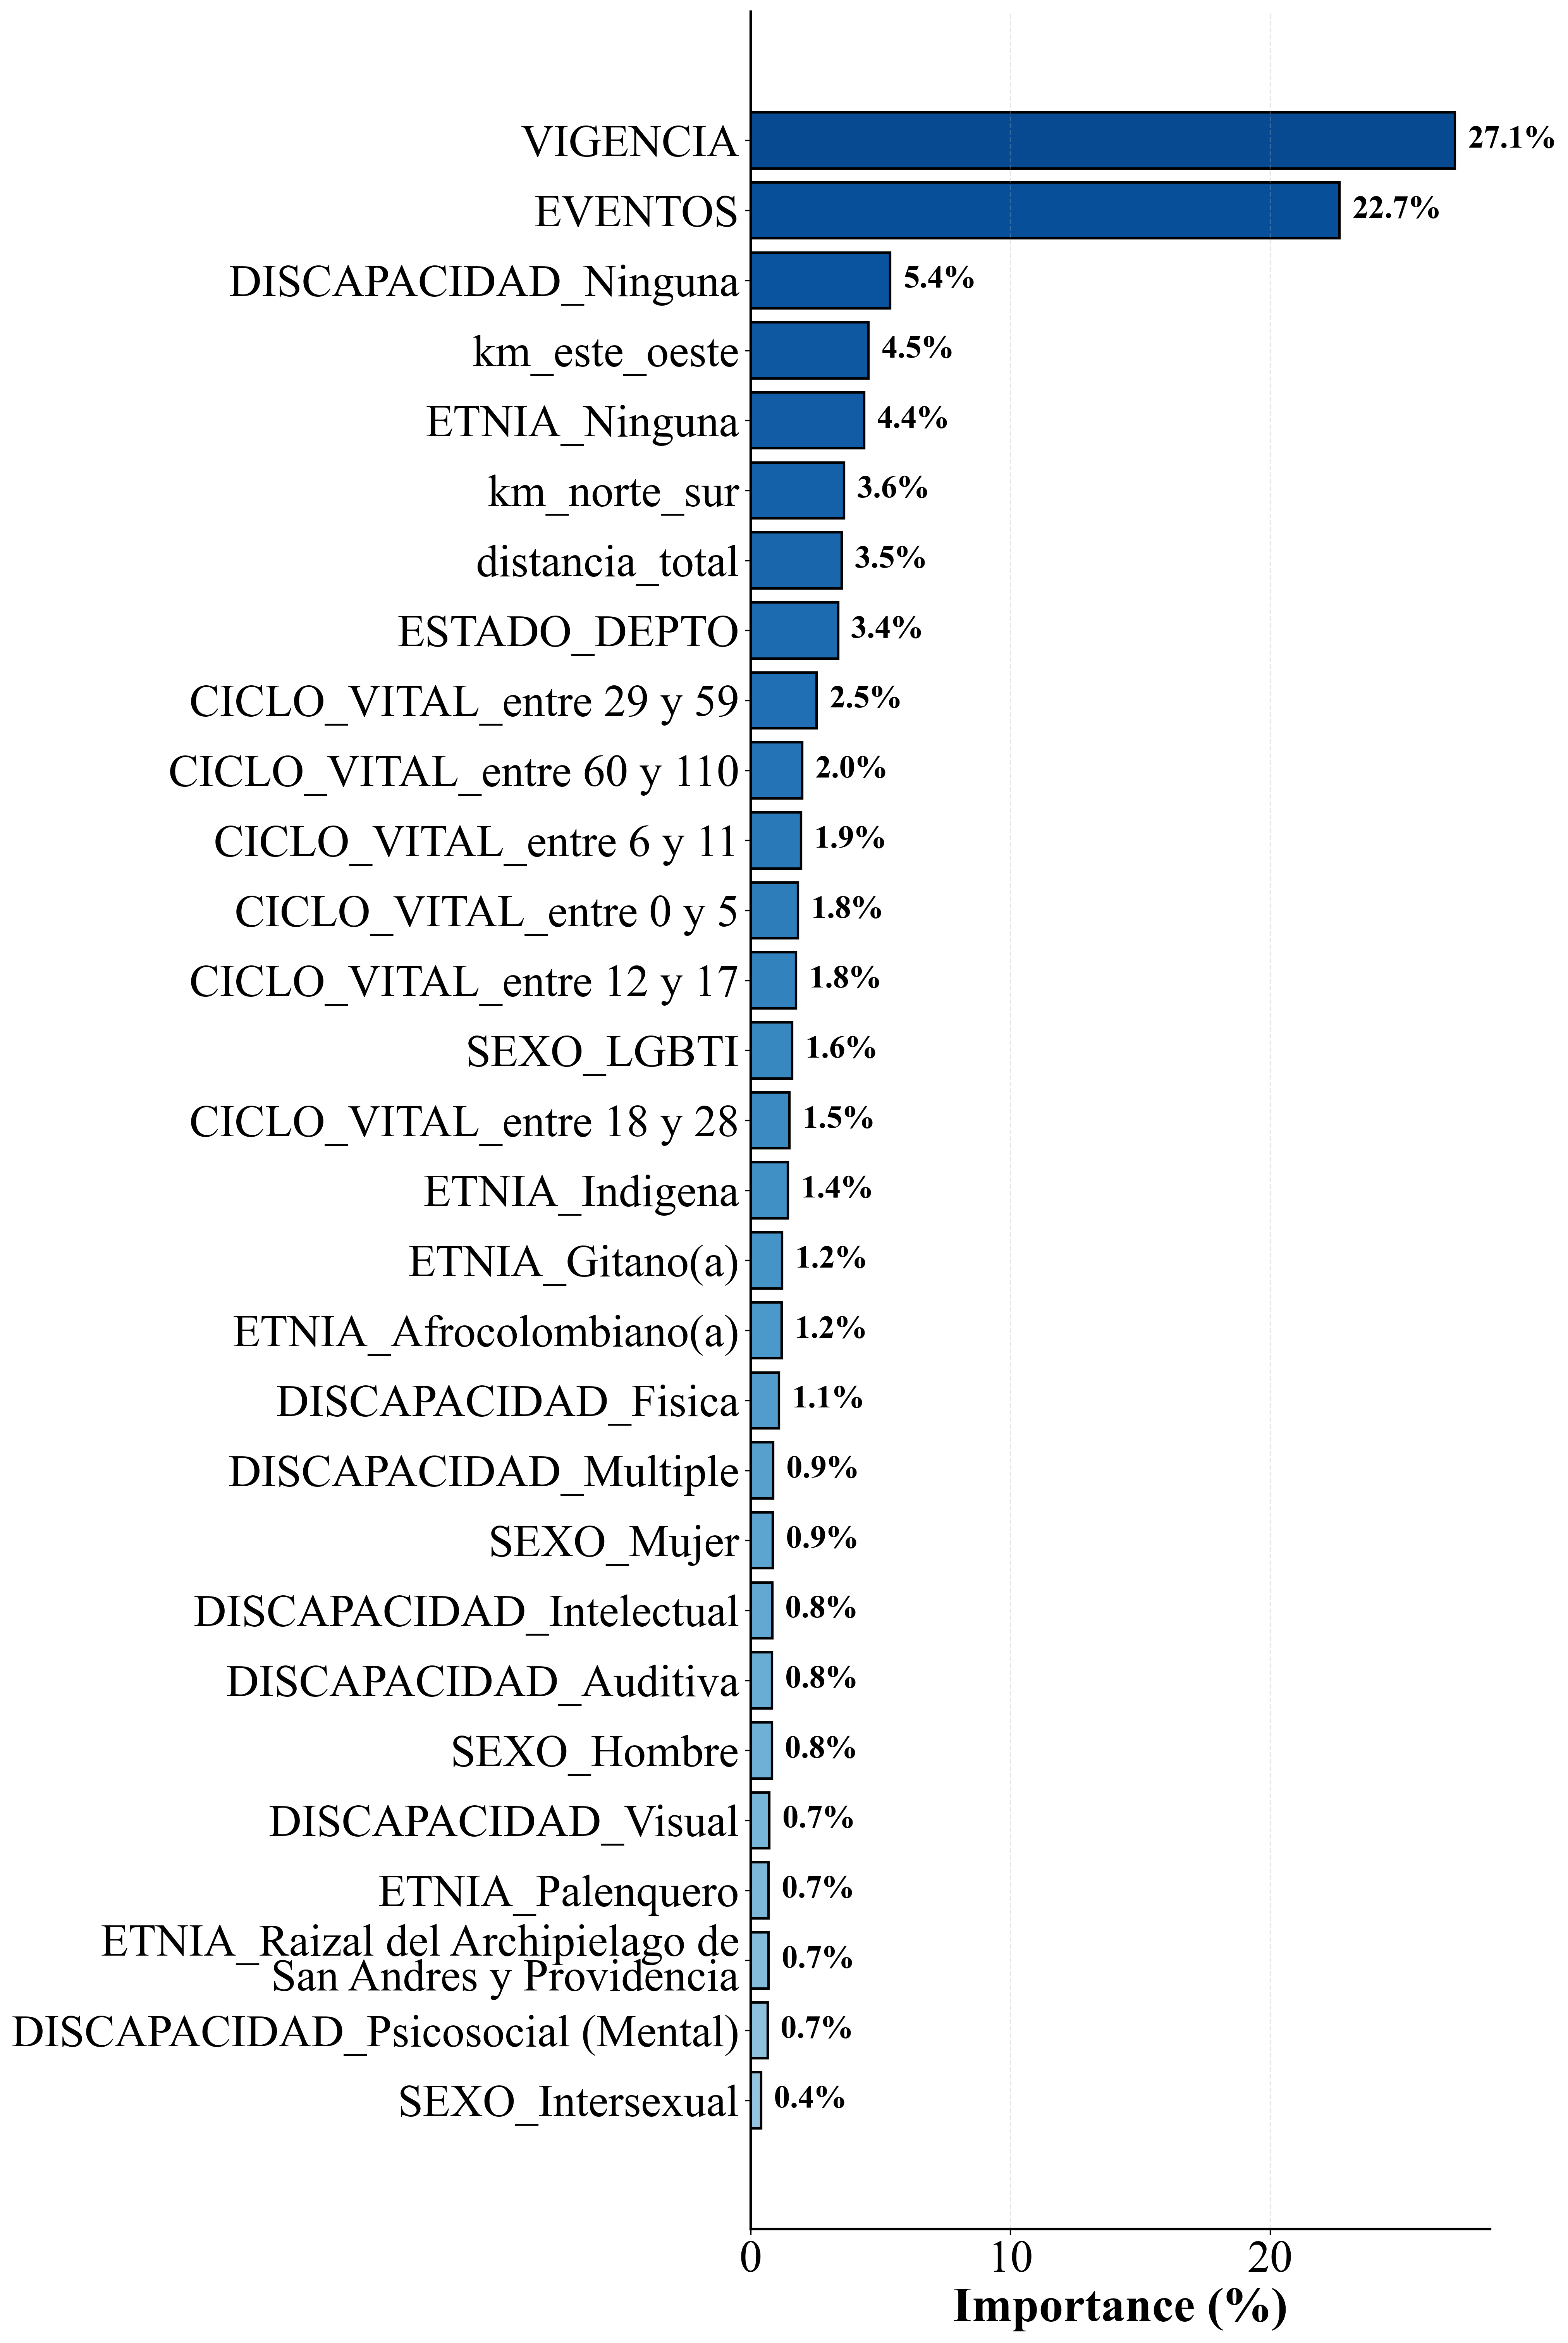


✓ Saved: feature_importance.png
✓ Saved: feature_importance_table.xlsx


In [15]:
create_feature_importance()